In [1]:
%cd C:\Users\yukir\Documents\GitHub\sign_detection\py

C:\Users\yukir\Documents\GitHub\sign_detection\py


In [2]:
from basic_preprocessing import *
from deeplearning_check import *

gpu_check()
set_global_determinism(seed=SEED)

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17315009996358319384
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17632728829490575964
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9883535296
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6243739309656544763
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 764210548828134728
physical_device_desc: "device: XLA_GPU device"
]
tf 2.2.0
keras 2.3.0-tf


#### basic model

In [3]:
%cd C:\Users\yukir\Documents\Monicas_workspace\Datasets\[0823]output

C:\Users\yukir\Documents\Monicas_workspace\Datasets\[0823]output


In [4]:
train_dir = "train"
test_dir = "test"
val_dir = "val"

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
from keras import Input
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=16, target_size=(200,200), color_mode='rgb')
val_generator = val_datagen.flow_from_directory(val_dir, batch_size=16, target_size=(200, 200), color_mode='rgb')
test_generator = test_datagen.flow_from_directory(test_dir,batch_size=16, target_size=(200, 200), color_mode='rgb')

input_tensor = Input(shape=(200, 200, 3), dtype='float32', name='input')

Found 548 images belonging to 4 classes.
Found 68 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


#### model creating

In [7]:
def create_model():
    optimizer = Adam()
    
    pre_trained_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
    #include_top FC 레이어 포함유무 결정
    #feature extraction 파라미터들은 이미지넷으로 학습된 값들을 그대로 사용할 것이기 때문에 trainable의 속성을 False
    pre_trained_vgg.trainable = False
    additional_model = tf.keras.Sequential()
    additional_model.add(pre_trained_vgg)
    additional_model.add(Flatten())
    additional_model.add(tf.keras.layers.Dense(4096, activation='relu'))
    additional_model.add(tf.keras.layers.Dense(2048, activation='relu'))
    additional_model.add(tf.keras.layers.Dense(1024, activation='relu'))
    additional_model.add(tf.keras.layers.Dense(4, activation='softmax'))
    

    additional_model.compile(optimizer = optimizer, loss = keras.losses.categorical_crossentropy, metrics=['acc'])

    
    return additional_model

In [8]:
tf.__version__

'2.2.0'

In [9]:
keras.__version__

'2.3.0-tf'

In [10]:
# 모델 실행 옵션 
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              75501568  
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 4100      
Total params: 100,709,188
Trainable params: 85,994,500
Non-trainable params: 14,714,688
__________________________________

In [11]:
checkpoint_path = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [12]:
#모델의 가중치 저장
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
            monitor='loss', 
            mode='min',
            save_best_only=True,
            save_weights_only=True,
            verbose=1)

#새로운 콜백으로 모델 훈련하기
history = model.fit_generator(train_generator, 
            steps_per_epoch=math.ceil(train_generator.n / train_generator.batch_size), 
            epochs=100, 
            validation_data=val_generator, 
            validation_steps=math.ceil(val_generator.n / val_generator.batch_size), 
            callbacks=[checkpoint],
            shuffle=False)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
35/35 [==============================] - ETA: 0s - loss: 3.3778 - acc: 0.5712
Epoch 00001: loss improved from inf to 3.37778, saving model to training_2/cp.ckpt
35/35 [==============================] - 7s 210ms/step - loss: 3.3778 - acc: 0.5712 - val_loss: 0.6856 - val_acc: 0.7794
Epoch 2/100
35/35 [==============================] - ETA: 0s - loss: 0.2354 - acc: 0.9234- ETA: 1s - loss: 0.3727 - acc: - ETA: 1s - loss: 0.3081  - ETA: 0s - loss: 0.2495 -
Epoch 00002: loss improved from 3.37778 to 0.23539, saving model to training_2/cp.ckpt
35/35 [==============================] - 6s 183ms/step - loss: 0.2354 - acc: 0.9234 - val_loss: 0.2708 - val_acc: 0.9118
Epoch 3/100
34/35 [============================>.] - ETA: 0s - loss: 0.1478 - acc: 0.9449- ETA: 1s - loss: 0
Epoch 00003: loss improved from 0.23539 to 0.14671, saving model to training_2/cp.ckpt
35/35 [==============================] - 7s 194ms/st

34/35 [============================>.] - ETA: 0s - loss: 1.0200e-05 - acc: 1.0000- ETA: 0s - loss: 8.6925e-06 - ac - ETA: 0s - loss: 1.0379e-05 - acc: 1.
Epoch 00026: loss improved from 0.00001 to 0.00001, saving model to training_2/cp.ckpt
35/35 [==============================] - 7s 191ms/step - loss: 1.0126e-05 - acc: 1.0000 - val_loss: 0.7155 - val_acc: 0.9118
Epoch 27/100
34/35 [============================>.] - ETA: 0s - loss: 7.9793e-06 - acc: 1.0000- ETA: 1s - loss: 1.4616
Epoch 00027: loss improved from 0.00001 to 0.00001, saving model to training_2/cp.ckpt
35/35 [==============================] - 7s 192ms/step - loss: 7.9210e-06 - acc: 1.0000 - val_loss: 0.7240 - val_acc: 0.9118
Epoch 28/100
34/35 [============================>.] - ETA: 0s - loss: 6.3778e-06 - acc: 1.0000- ETA: 1s - loss: 1.1387e-05 - acc: 1.0 - ETA: 1s - loss: 9.01
Epoch 00028: loss improved from 0.00001 to 0.00001, saving model to training_2/cp.ckpt
35/35 [==============================] - 7s 191ms/step - lo

35/35 [==============================] - 7s 190ms/step - loss: 5.6296e-07 - acc: 1.0000 - val_loss: 0.8277 - val_acc: 0.9118
Epoch 49/100
34/35 [============================>.] - ETA: 0s - loss: 3.5170e-07 - acc: 1.0000- ETA: 1s - loss: 3.0966e-07 - - ETA: 0s - loss: 4.2148e-07 - acc: 
Epoch 00049: loss improved from 0.00000 to 0.00000, saving model to training_2/cp.ckpt
35/35 [==============================] - 7s 190ms/step - loss: 5.1902e-07 - acc: 1.0000 - val_loss: 0.8332 - val_acc: 0.9118
Epoch 50/100
34/35 [============================>.] - ETA: 0s - loss: 4.5228e-07 - acc: 1.0000- ETA: 1s - lo
Epoch 00050: loss improved from 0.00000 to 0.00000, saving model to training_2/cp.ckpt
35/35 [==============================] - 7s 188ms/step - loss: 4.4898e-07 - acc: 1.0000 - val_loss: 0.8374 - val_acc: 0.9118
Epoch 51/100
34/35 [============================>.] - ETA: 0s - loss: 4.2380e-07 - acc: 1.0000
Epoch 00051: loss improved from 0.00000 to 0.00000, saving model to training_2/cp.ckp

35/35 [==============================] - 7s 190ms/step - loss: 1.2030e-07 - acc: 1.0000 - val_loss: 0.9140 - val_acc: 0.9118
Epoch 72/100
34/35 [============================>.] - ETA: 0s - loss: 1.1592e-07 - acc: 1.0000
Epoch 00072: loss improved from 0.00000 to 0.00000, saving model to training_2/cp.ckpt
35/35 [==============================] - 7s 189ms/step - loss: 1.1508e-07 - acc: 1.0000 - val_loss: 0.9166 - val_acc: 0.9118
Epoch 73/100
34/35 [============================>.] - ETA: 0s - loss: 1.1110e-07 - acc: 1.0000
Epoch 00073: loss improved from 0.00000 to 0.00000, saving model to training_2/cp.ckpt
35/35 [==============================] - 7s 187ms/step - loss: 1.1029e-07 - acc: 1.0000 - val_loss: 0.9202 - val_acc: 0.9118
Epoch 74/100
34/35 [============================>.] - ETA: 0s - loss: 1.0562e-07 - acc: 1.0000- ETA: 0s - loss: 1.1176e-07 - acc: 1.00
Epoch 00074: loss improved from 0.00000 to 0.00000, saving model to training_2/cp.ckpt
35/35 [==============================] 

Epoch 95/100
34/35 [============================>.] - ETA: 0s - loss: 4.4923e-08 - acc: 1.0000- ETA: 1s - loss: 2.3416e-08 - acc: 1 - ETA: 1s - loss: 6.5813e-08 - acc: 1.00 - ETA: 1s - loss: 5.74
Epoch 00095: loss improved from 0.00000 to 0.00000, saving model to training_2/cp.ckpt
35/35 [==============================] - 7s 192ms/step - loss: 4.4595e-08 - acc: 1.0000 - val_loss: 0.9808 - val_acc: 0.9118
Epoch 96/100
34/35 [============================>.] - ETA: 0s - loss: 4.3169e-08 - acc: 1.0000- ETA: 0s - loss: 4.7282e-08 - acc:  - ETA: 0s - loss: 4.5402e-08 - acc: 1.00
Epoch 00096: loss improved from 0.00000 to 0.00000, saving model to training_2/cp.ckpt
35/35 [==============================] - 7s 191ms/step - loss: 4.2854e-08 - acc: 1.0000 - val_loss: 0.9824 - val_acc: 0.9118
Epoch 97/100
34/35 [============================>.] - ETA: 0s - loss: 4.1855e-08 - acc: 1.0000- ETA: 1s - loss: 6.8711e- - ETA: 0s - loss: 4.7088e-08 - acc: 1 - ETA: 0s - loss: 4.7187e-08 - acc: 1.0 - ETA: 0s

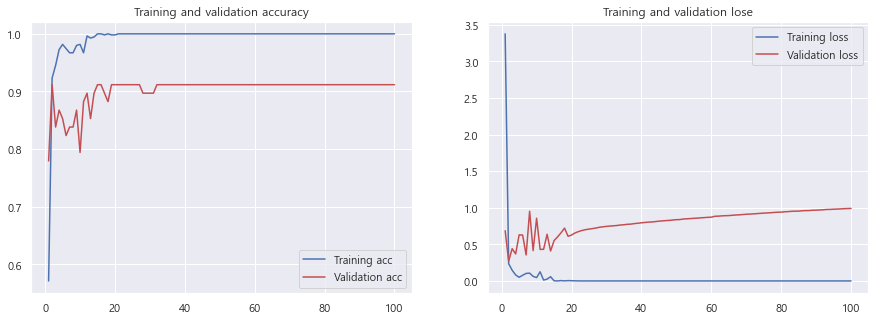

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) +1)
    
    

fig = plt.figure()
fig.set_size_inches(15, 5)

fig.add_subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label ='Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# plt.figure()
fig.add_subplot(1, 2, 2) 
plt.plot(epochs, loss, 'b', label = "Training loss")
plt.plot(epochs, val_loss, 'r', label ='Validation loss')
plt.title('Training and validation lose')
plt.legend()

plt.show()

In [20]:
#맥에서는 !ls
#저장된 checkpoint확인하기
!dir {checkpoint_dir}

 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: 5848-7E5C

 C:\Users\yukir\Documents\Monicas_workspace\Datasets\[0823]output\training_2 디렉터리

2021-08-24  오후 02:25    <DIR>          .
2021-08-24  오후 02:25    <DIR>          ..
2021-08-24  오후 02:25                71 checkpoint
2021-08-24  오후 02:24             7,593 cp.ckpt.data-00000-of-00002
2021-08-24  오후 02:24     1,090,792,776 cp.ckpt.data-00001-of-00002
2021-08-24  오후 02:25             4,030 cp.ckpt.index
               4개 파일       1,090,804,470 바이트
               2개 디렉터리  323,919,159,296 바이트 남음


In [21]:
#가장 마지막에 만들어진 체크포인트 확인
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'training_2\\cp.ckpt'

In [22]:
# 기본 모델 객체를 만듭니다
model = create_model()

# 모델을 평가합니다
loss, acc = model.evaluate(test_generator, verbose=2)
print("훈련되지 않은 모델의 정확도: {:5.2f}%".format(100*acc))

5/5 - 0s - loss: 1.4770 - acc: 0.2361
훈련되지 않은 모델의 정확도: 23.61%


In [23]:
# 가중치 로드
model.load_weights(latest)

# 모델 재평가
loss,acc = model.evaluate(test_generator)
print("복원된 모델의 정확도: {:5.2f}%".format(100*acc))

5/5 [==============================] - 0s 39ms/step - loss: 0.8015 - acc: 0.8889
복원된 모델의 정확도: 88.89%


#### final model save

In [24]:
model_json = model.to_json()
with open("[0823](0.889)vgg_new_cb.json", "w") as json_file : 
    json_file.write(model_json)

model.save_weights("[0823](0.889)vgg_new_cb.h5")
print("Saved model to disk")

Saved model to disk


#### confusion matrix

In [131]:
#confusion matrix
from sklearn.metrics import confusion_matrix

# 1.Predict classes
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)


predictions = model.predict_generator(test_generator, steps=test_steps_per_epoch)

# Get most likely class axis=1(열로 가장 큰 수의 위치를 보겠다는 소리), 
predicted_classes = np.argmax(predictions, axis=1)

print(predicted_classes)
# 2.Get ground-truth classes and class-labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   
# 3. Use scikit-learn to get statistics
report = classification_report(true_classes, predicted_classes, target_names=class_labels)


print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, predicted_classes))
print(report)    

72
[3 0 0 0 0 3 2 2 2 0 1 0 3 3 2 0 2 0 1 2 2 1 2 0 0 2 0 0 0 0 2 0 3 0 0 0 1
 3 0 2 0 1 3 0 0 2 3 2 0 3 0 3 1 0 0 0 0 0 2 0 1 0 2 1 1 3 3 2 1 1 3 0]
Confusion Matrix
[[14  3 10  4]
 [ 6  2  1  2]
 [10  1  3  4]
 [ 2  5  2  3]]
              precision    recall  f1-score   support

     fragile       0.44      0.45      0.44        31
      handle       0.18      0.18      0.18        11
          up       0.19      0.17      0.18        18
         wet       0.23      0.25      0.24        12

    accuracy                           0.31        72
   macro avg       0.26      0.26      0.26        72
weighted avg       0.30      0.31      0.30        72



#### Real pic test - need to correct file_name as label

In [192]:
get_label_dict(train_generator)

{0: 'fragile', 1: 'handle', 2: 'up', 3: 'wet'}

In [204]:
def file_list(path):
    file_list = os.listdir(path)
    file_list.sort()
    file_list = file_list[1:]
    list_file = []
    for i in file_list:
        list_file.append(path+i)
    return list_file

path ='C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\Real_test\\resizing\\'

file_list = file_list(path)

results={
   0:'fragile',
   1:'handle',
   2:'up',
   3:'wet'
}
columns =['file_name', 'label', 'class']
answer = []
for i in file_list:
    im=Image.open(i)
    # the input image is required to be in the shape of dataset, i.e (32,32,3)
    i= i.split('\\')[-1]
    im=im.resize((200,200))
    im=np.expand_dims(im,axis=0) #차원으로 분리
    im=np.array(im)
    pred=model.predict_classes([im])[0]
    answer.append([i, pred, results[pred]])
    answer_df = pd.DataFrame(answer, columns = columns )
answer_df.head()

,file_name,label,class
0,box_false.JPG,0,fragile
1,box_fragile.JPG,0,fragile
2,cold.JPG,2,up
3,cut (2).JPG,1,handle
4,cut (3).JPG,1,handle


In [205]:
answer_df["class"].value_counts()

fragile    18
handle      7
up          4
wet         1
Name: class, dtype: int64

In [207]:
File_Name = answer_df.file_name.tolist()
# f_n=[]
# for i in File_Name:
#     i = i.split(' ')[0]
#     f_n.append(i)

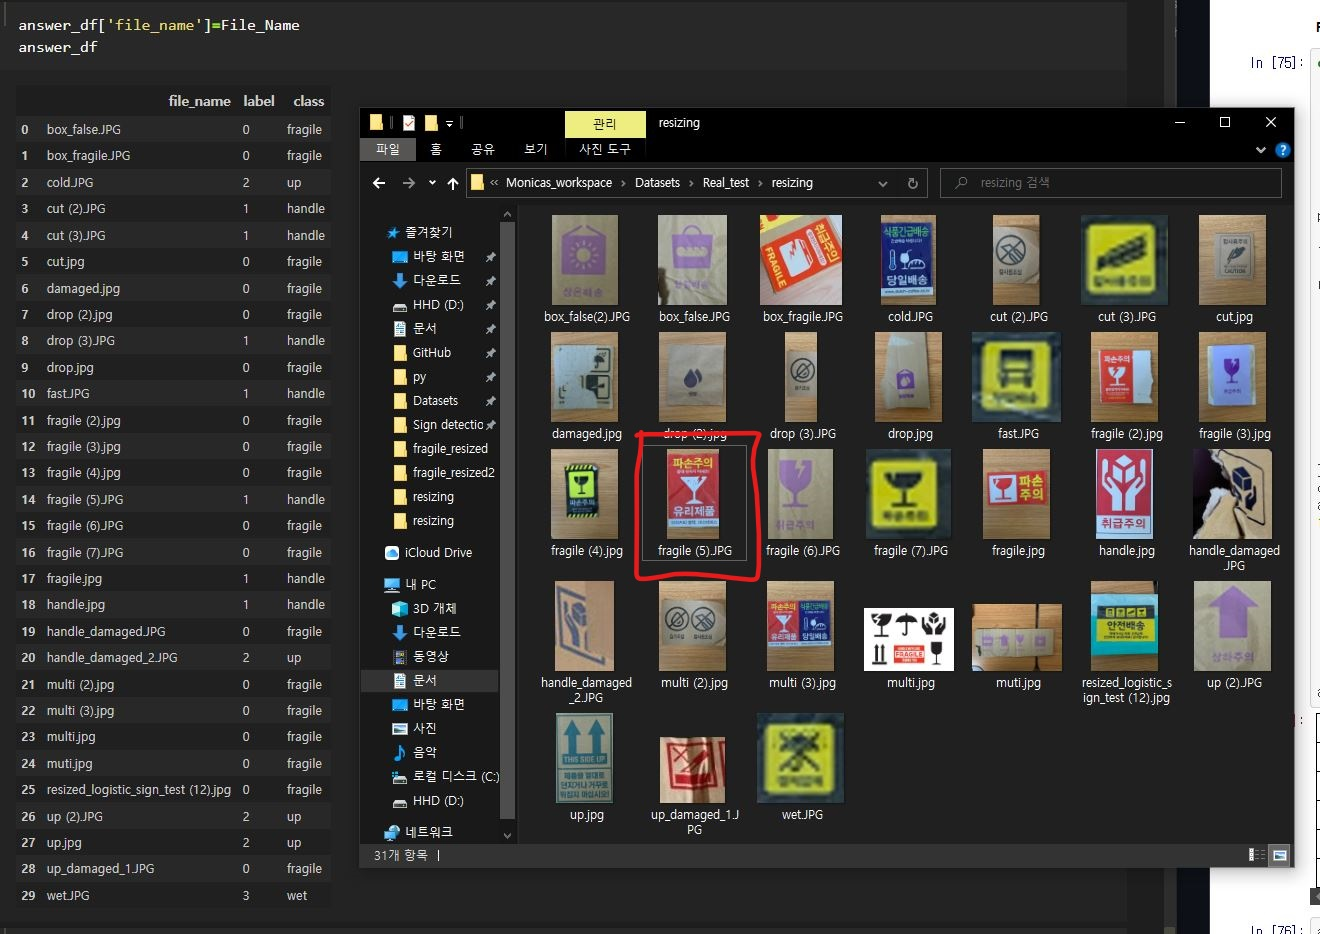

In [214]:
from IPython.display import Image
Image("C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\Real_test\\Inked(0824)88.89 non_damaged_LI.JPG")

In [208]:
answer_df['file_name']=File_Name
answer_df

,file_name,label,class
0,box_false.JPG,0,fragile
1,box_fragile.JPG,0,fragile
2,cold.JPG,2,up
3,cut (2).JPG,1,handle
4,cut (3).JPG,1,handle
5,cut.jpg,0,fragile
6,damaged.jpg,0,fragile
7,drop (2).jpg,0,fragile
8,drop (3).JPG,1,handle
9,drop.jpg,0,fragile
